<a href="https://colab.research.google.com/github/aaronmat1905/the-tokenized-tech/blob/main/LLM%20Engineering/Agentic%20AI/AgentsByHand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Tokenized Tech**\
Intro to Agents, the old fashioned way


## Configure Imports and API Credentials

In [1]:
import os
import requests

In [2]:
# --- For Google Colab Users ---
from google.colab import userdata

# Retrieve Gemini API key securely from Colab's userdata storage
api_key = userdata.get("GeminiAPI") or "REPLACE-YOUR-GEMINI-API-KEY-HERE"

# --- For Local Development Environments ---
# Uncomment the lines below when running outside Colab

# import os
# from dotenv import load_dotenv
# load_dotenv()  # Load environment variables from a .env file
# api_key = os.getenv("GEMINI_API_KEY")

## Initializing the **Gemini Client**
*Custom Implementation*

In [3]:
class GeminiClient:
	def __init__(self, api_key: str):
		self.api_key = api_key
		self.endpoint = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent"
		self.headers = {
			"x-goog-api-key": self.api_key,
			"Content-Type": "application/json"
			}
	def generate_content(self, prompt) -> str:
		payload = {
			"contents": [
					{ "parts":[{"text":prompt}]}
				]
		}
		response = requests.post(self.endpoint, headers= self.headers, json = payload)
		if response.status_code ==200:
			data = response.json()
			try:
				return data['candidates'][0]['content']['parts'][0]['text']
			except (KeyError, IndexError):
				return "No response text found"
		else:
			return f"Error: {response.status_code} - {response.text}"

In [4]:
# Useage of our custom client:
client = GeminiClient(api_key)

In [5]:
# Sample Prompt:
prompt = "Explain what are AI Agents in a sentence."
response = client.generate_content(prompt)
print(f"Response: {response}")

Response: AI Agents are autonomous AI programs or systems designed to perceive their environment and take actions to achieve specific goals.


## Define **Tool Registry** and associated Tools

In [6]:
# Tool Registry:
class Tool:
    def __init__(self):
        self.tools = {}

    def registerTool(self, name=None, description=None):
        """Records a Tool"""
        def decorator(func):
            tool_name = name or func.__name__
            self.tools[tool_name] = {
                "function_name": func,
                "description": description or func.__doc__,
                "call": lambda *args, **kwargs: func(*args, **kwargs)
            }
            return func
        return decorator

    def call(self, tool_name: str, *args, **kwargs):
        if tool_name not in self.tools:
            raise ValueError(f"Tool '{tool_name}' does not exist.")
        return self.tools[tool_name]["call"](*args, **kwargs)

    def list_tools(self):
        return {name: meta["description"] for name, meta in self.tools.items()}


In [7]:
# Creating an instance of the Tool Registry:
toolFamily = Tool()

**Problem Statement:**  Create an Agent for Personal Financial Wellness & Life Planning

**Emergency Fund Calculator** \
Figures out how much money you should save for emergencies.

In [27]:
@toolFamily.registerTool()
def calculate_emergency_fund_goal(monthly_expenses, job_stability, dependents):
    """
    Calculate personalized emergency fund target based on life situation.
    Args:
        monthly_expenses (float): Monthly living expenses.
        job_stability (str): "stable", "moderate", "unstable" - job security level.
        dependents (int): Number of dependents (spouse, kids, parents).
    Returns:
        dict: Emergency fund recommendations and savings plan.
    """
    base_months = 3

    # Adjust based on job stability
    if job_stability == "stable":
        months_needed = base_months
    elif job_stability == "moderate":
        months_needed = base_months + 2
    else:  # unstable
        months_needed = base_months + 4

    # Add buffer for dependents
    months_needed += dependents * 0.5

    target_amount = monthly_expenses * months_needed
    monthly_savings_needed = target_amount / 12  # Build over 1 year

    return {
        "target_amount": round(target_amount, 2),
        "months_covered": round(months_needed, 1),
        "monthly_savings_goal": round(monthly_savings_needed, 2),
        "weekly_savings_goal": round(monthly_savings_needed / 4, 2),
        "motivation": f"This covers {months_needed} months of expenses - you'll sleep better!"
    }
## Let us call the tool
toolFamily.call('calculate_emergency_fund_goal', 3500, 'moderate', 2)

{'target_amount': 21000.0,
 'months_covered': 6.0,
 'monthly_savings_goal': 1750.0,
 'weekly_savings_goal': 437.5,
 'motivation': "This covers 6.0 months of expenses - you'll sleep better!"}

**Vacation Savings Planner**\
Purpose: Helps you save money for your next trip with weekly goals.

In [28]:
@toolFamily.registerTool()
def calculate_vacation_savings_plan(destination, trip_cost, departure_date, current_savings):
    """
    Create a personalized vacation savings plan with weekly goals.
    Args:
        destination (str): Where you're going (for motivation).
        trip_cost (float): Total estimated trip cost.
        departure_date (str): When you're leaving (YYYY-MM-DD).
        current_savings (float): Amount already saved.
    Returns:
        dict: Savings plan with weekly targets and motivation.
    """
    from datetime import datetime

    departure = datetime.strptime(departure_date, "%Y-%m-%d")
    today = datetime.now()
    days_until_trip = (departure - today).days
    weeks_until_trip = days_until_trip / 7

    amount_still_needed = trip_cost - current_savings

    if weeks_until_trip <= 0:
        return {"error": "Trip date has passed or is today!"}

    weekly_savings_needed = amount_still_needed / weeks_until_trip

    progress_percentage = (current_savings / trip_cost) * 100

    return {
        "destination": destination,
        "days_until_trip": days_until_trip,
        "weekly_savings_needed": round(weekly_savings_needed, 2),
        "daily_savings_needed": round(weekly_savings_needed / 7, 2),
        "progress_percentage": round(progress_percentage, 2),
        "motivation": f"Just ${round(weekly_savings_needed, 2)} per week until you're in {destination}!",
        "coffee_equivalent": f"That's about {round(weekly_savings_needed / 5, 0)} coffees per week"
    }

# Vacation Savings Planner:
toolFamily.call('calculate_vacation_savings_plan', 'Hawaii', 5000, '2025-12-15', 1200)

{'destination': 'Hawaii',
 'days_until_trip': 142,
 'weekly_savings_needed': 187.32,
 'daily_savings_needed': 26.76,
 'progress_percentage': 24.0,
 'motivation': "Just $187.32 per week until you're in Hawaii!",
 'coffee_equivalent': "That's about 37.0 coffees per week"}

**Buy vs Rent Analyzer**\
Purpose: Shows whether it's better to buy or rent a home for your situation.

In [30]:
@toolFamily.registerTool()
def calculate_buying_vs_renting(home_price, rent_price, down_payment, years_staying, annual_home_appreciation):
    """
    Compare the financial impact of buying vs renting for your situation.
    Args:
        home_price (float): Purchase price of the home.
        rent_price (float): Monthly rent cost.
        down_payment (float): Down payment amount.
        years_staying (int): How long you plan to stay.
        annual_home_appreciation (float): Expected annual home value growth percentage.
    Returns:
        dict: Detailed buy vs rent analysis with recommendation.
    """
    # Buying costs
    loan_amount = home_price - down_payment
    monthly_mortgage = loan_amount * 0.005  # Simplified 6% rate
    property_tax = home_price * 0.015 / 12  # 1.5% annually
    insurance = home_price * 0.005 / 12  # 0.5% annually
    maintenance = home_price * 0.01 / 12  # 1% annually

    monthly_buying_cost = monthly_mortgage + property_tax + insurance + maintenance

    # Future home value
    future_home_value = home_price * ((1 + annual_home_appreciation/100) ** years_staying)

    # Total costs over period
    total_buying_cost = (monthly_buying_cost * years_staying * 12) + down_payment
    total_renting_cost = rent_price * years_staying * 12

    # Equity gained
    equity_gained = future_home_value - loan_amount
    net_buying_cost = total_buying_cost - equity_gained

    savings = total_renting_cost - net_buying_cost

    recommendation = "Buy" if savings > 0 else "Rent"

    return {
        "monthly_mortgage_payment": round(monthly_mortgage, 2),
        "total_monthly_ownership_cost": round(monthly_buying_cost, 2),
        "monthly_rent": rent_price,
        "equity_after_years": round(equity_gained, 2),
        "total_savings_by_buying": round(savings, 2),
        "recommendation": recommendation,
        "break_even_years": round(abs(savings) / (abs(monthly_buying_cost - rent_price) * 12), 1),
        "personal_advice": f"If you're staying {years_staying} years, {recommendation.lower()}ing saves you ${abs(round(savings, 2))}"
    }
# Buying vs. Renting
toolFamily.call('calculate_buying_vs_renting', 400000, 2500, 80000, 5, 3.5)

{'monthly_mortgage_payment': 1600.0,
 'total_monthly_ownership_cost': 2600.0,
 'monthly_rent': 2500,
 'equity_after_years': 155074.52,
 'total_savings_by_buying': 69074.52,
 'recommendation': 'Buy',
 'break_even_years': 57.6,
 'personal_advice': "If you're staying 5 years, buying saves you $69074.52"}

**Coffee Shop Savings Calculator**\
Purpose: Shows how much you could save by making coffee at home instead of buying it.

In [31]:
@toolFamily.registerTool()
def calculate_coffee_shop_savings(daily_coffee_cost, brewing_cost_per_cup, workdays_per_week):
    """
    Calculate how much you could save by making coffee at home vs buying.
    Args:
        daily_coffee_cost (float): Cost of your daily coffee shop visit.
        brewing_cost_per_cup (float): Cost to make coffee at home.
        workdays_per_week (int): How many days per week you buy coffee.
    Returns:
        dict: Savings analysis with fun comparisons.
    """
    daily_savings = daily_coffee_cost - brewing_cost_per_cup
    weekly_savings = daily_savings * workdays_per_week
    monthly_savings = weekly_savings * 4.33  # Average weeks per month
    annual_savings = monthly_savings * 12

    # Fun comparisons
    netflix_subscriptions = annual_savings / 180  # ~$15/month
    vacation_fund = annual_savings / 2000  # Decent vacation cost

    return {
        "daily_savings": round(daily_savings, 2),
        "weekly_savings": round(weekly_savings, 2),
        "monthly_savings": round(monthly_savings, 2),
        "annual_savings": round(annual_savings, 2),
        "netflix_equivalent": round(netflix_subscriptions, 1),
        "vacation_fund_portion": round(vacation_fund, 2),
        "fun_fact": f"In 10 years, you'd save ${round(annual_savings * 10, 2)} - that's a car!",
        "motivation": f"Skip the coffee shop {workdays_per_week} days a week = ${round(monthly_savings, 2)} extra per month"
    }

# Coffee Shop savings
toolFamily.call('calculate_coffee_shop_savings', 5.50, 0.75, 5)

{'daily_savings': 4.75,
 'weekly_savings': 23.75,
 'monthly_savings': 102.84,
 'annual_savings': 1234.05,
 'netflix_equivalent': 6.9,
 'vacation_fund_portion': 0.62,
 'fun_fact': "In 10 years, you'd save $12340.5 - that's a car!",
 'motivation': 'Skip the coffee shop 5 days a week = $102.84 extra per month'}

**Subscription Audit Tool**\
Purpose: Finds subscriptions you're paying for but not really using.

In [32]:
@toolFamily.registerTool()
def calculate_subscription_audit(subscriptions_list, monthly_usage_hours):
    """
    Analyze your subscription spending and find savings opportunities.
    Args:
        subscriptions_list (list): List of dicts with 'name', 'cost', 'frequency' (monthly/annual).
        monthly_usage_hours (dict): Dict with subscription names as keys, usage hours as values.
    Returns:
        dict: Subscription analysis with recommendations.
    """
    total_monthly_cost = 0
    underused_subs = []

    for sub in subscriptions_list:
        monthly_cost = sub['cost'] if sub['frequency'] == 'monthly' else sub['cost'] / 12
        total_monthly_cost += monthly_cost

        usage = monthly_usage_hours.get(sub['name'], 0)
        cost_per_hour = monthly_cost / usage if usage > 0 else monthly_cost

        if usage < 5:  # Less than 5 hours per month
            underused_subs.append({
                'name': sub['name'],
                'monthly_cost': round(monthly_cost, 2),
                'usage_hours': usage,
                'cost_per_hour': round(cost_per_hour, 2)
            })

    potential_savings = sum([sub['monthly_cost'] for sub in underused_subs])

    return {
        "total_monthly_cost": round(total_monthly_cost, 2),
        "annual_cost": round(total_monthly_cost * 12, 2),
        "underused_subscriptions": underused_subs,
        "potential_monthly_savings": round(potential_savings, 2),
        "potential_annual_savings": round(potential_savings * 12, 2),
        "recommendation": f"Cancel {len(underused_subs)} underused subscriptions to save ${round(potential_savings, 2)}/month",
        "reality_check": f"You're spending ${round(total_monthly_cost, 2)}/month on subscriptions - that's a car payment!"
    }

# Calculate Subscriptioin Audit

toolFamily.call('calculate_subscription_audit',
    [
        {'name': 'Netflix', 'cost': 15.99, 'frequency': 'monthly'},
        {'name': 'Spotify', 'cost': 9.99, 'frequency': 'monthly'},
        {'name': 'Adobe Creative', 'cost': 239.88, 'frequency': 'annual'}
    ],
    {'Netflix': 20, 'Spotify': 40, 'Adobe Creative': 2}
)

{'total_monthly_cost': 45.97,
 'annual_cost': 551.64,
 'underused_subscriptions': [{'name': 'Adobe Creative',
   'monthly_cost': 19.99,
   'usage_hours': 2,
   'cost_per_hour': 9.99}],
 'potential_monthly_savings': 19.99,
 'potential_annual_savings': 239.88,
 'recommendation': 'Cancel 1 underused subscriptions to save $19.99/month',
 'reality_check': "You're spending $45.97/month on subscriptions - that's a car payment!"}

In [25]:
## Let us now see how these tools are registered in our system: Creating a repository of our tools:
for key, value in toolFamily.list_tools().items():
  print(key)
  print(value, "\n=================\n")

calculate_emergency_fund_goal

    Calculate personalized emergency fund target based on life situation.
    Args:
        monthly_expenses (float): Monthly living expenses.
        job_stability (str): "stable", "moderate", "unstable" - job security level.
        dependents (int): Number of dependents (spouse, kids, parents).
    Returns:
        dict: Emergency fund recommendations and savings plan.
     

calculate_vacation_savings_plan

    Create a personalized vacation savings plan with weekly goals.
    Args:
        destination (str): Where you're going (for motivation).
        trip_cost (float): Total estimated trip cost.
        departure_date (str): When you're leaving (YYYY-MM-DD).
        current_savings (float): Amount already saved.
    Returns:
        dict: Savings plan with weekly targets and motivation.
     

calculate_buying_vs_renting

    Compare the financial impact of buying vs renting for your situation.
    Args:
        home_price (float): Purchase price o

##**Working of Agents**: the Think-Act-Observe Loop

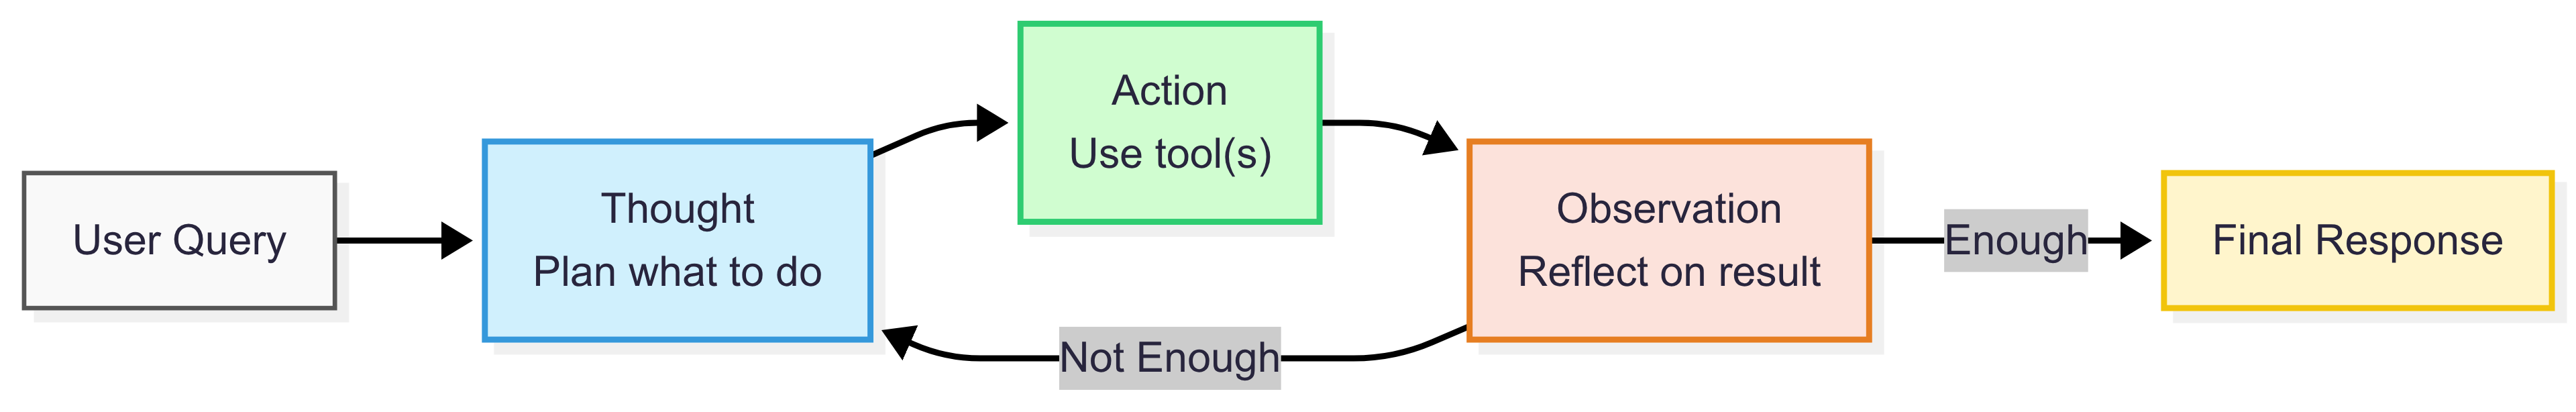

**Approach**:\
Every Agent works in a Thought-Action-Observation Cycle.

**Thought**: The Agent first reads the Query and plans the perfect set of steps that needs to be executed in order to get the query's output.

Here, We try to adopt a prompt-engineering approach, where we specify the list of tools that would be used for our project. The LLM would read our query and list the most appropriate tool call/s to get the output.

**Action**: Are the concrete steps an AI Agent Takes to interact with it's environment

In [19]:
# First, we would want our Agent to be a seperate object to make things easier:
class Agent():
  def __init__(self, work, toolfamily, llm_client):
    self.work = work
    self.toolfamily = toolfamily
    self.thought_prompt = self._buildThoughtPrompt(work, toolfamily)
    self.llm = llm_client

  def _buildThoughtPrompt(self, work, toollist:Tool) -> str:
    agentPrompt = f"You are an AI-system equipped with some tools. You are an expert {work}"
    outputGeneration = """
      You are expected to plan and reason the steps that need to be taken in order to arrive at the expected answer.
      Each step of your thinking should be shown as a dictionary element contained within a Python list.
      Each step should only contain the work related to the tool and nothing else.
      If the query can be resolved within a single step- go for it; Else document each step in the format given below.
      ```python
      [
        {
          "thought": "a-one-sentence-description-of-why-you-selected-this-tool",
          "action": (Tool_Name, *args, **kwargs)
        },
        ...
      ]
      ```
      Only generate this python object- do not generate any extra code or explainatory text
      Here are your Tools.
    """
    agentPrompt += outputGeneration
    for key, val in toolFamily.list_tools().items():
      samp = f"\nTool Name:\t{key}\nTool Description:\n{val}\n"
      agentPrompt += samp
    return agentPrompt

  def _think(self, query) -> list:
    """Runs the Thinking Step of the Agent"""
    prompt = f"{self.thought_prompt}\n\nHere is your Query {query}"
    answer = self.llm.generate_content(prompt)
    answer = answer.replace("python", "").replace("```", "")
    return eval(answer)

  def _act(self, thought: list[dict]) -> list:
      results = []
      for step in thought:
          action_tuple = step.get("action")
          if not action_tuple:
              continue
          tool_name, *args = action_tuple
          tool_fn = self.toolfamily.tools[tool_name]["function_name"]

          # Handle case: single argument which is a dict → unpack as kwargs
          if len(args) == 1 and isinstance(args[0], dict):
              result = tool_fn(**args[0])
          else:
              result = tool_fn(*args)

          results.append(result)
      return results
  def _observe(self, query, thought, data):
    prompt = f"""
      You are a finance agent- and you have performed certain operations.
      The query that was given to you was:
        {query}
      The Thought you processed was:
        {thought}
      The Data You recieved was:
        {data}
      Now, combine these information and give a suitable reply for the user.
      Notes: Give Smart financial answers related to the query-- and your answer should satisfy the user's question.
    """
    answer = self.llm.generate_content(prompt)
    return answer

  def run(self, query):
    thoughts = self._think(query)
    action = self._act(thoughts)
    observation = self._observe(query, thoughts, action)
    return observation

In [20]:
financeAgent = Agent(
    work = "Financial Agent",
    toolfamily= toolFamily,
    llm_client= client
)

In [21]:
multi_action_prompt = """
Hey, I’m trying to take control of my finances and need your help with a few things.

1. I want to plan a trip to Sri Lanka that will cost me about ₹45,000. I currently have ₹3,000 saved and I’m hoping to leave in mid-December this year(2025). Can you tell me how much I need to save weekly to make it?

2. Also, I live alone in Bangalore, spend around ₹25,000 a month, and work in a startup, so my job stability is moderate. I have two dependents: my mom and younger brother. Can you tell me what my emergency fund goal should be?

3. Lastly, I’ve got a bunch of subscriptions that I’m not sure I’m using wisely. Here’s the list:
   - Netflix: ₹649/month, ~10 hours/month
   - Spotify: ₹119/month, ~20 hours/month
   - Notion AI: ₹800/year, ~5 hours/month
   - Headspace: ₹500/year, ~1 hour/month

Please audit this and tell me where I’m wasting money.
Could you give me a list of where all I should save this money?
Help me prioritize all this!
"""
result = financeAgent.run(multi_action_prompt)

In [22]:
import markdown
from IPython.display import Markdown
display(Markdown(result))
# result

It's great that you're taking control of your finances! Let's break down each of your goals and create a clear plan.

### 1. Sri Lanka Trip Savings Plan

This is an exciting goal! To reach your ₹45,000 target by mid-December 2025 with ₹3,000 already saved:

*   **Days until trip:** You have approximately **142 days** (about 20 weeks) until your desired departure date of December 15, 2025.
*   **Amount needed:** You need to save an additional **₹42,000** (₹45,000 - ₹3,000).
*   **Weekly Savings Goal:** To achieve this, you'll need to save approximately **₹2,070.42 per week**.
*   **Daily Savings Goal:** This breaks down to about **₹295.77 per day**.

Keep going, you've already made 6.67% progress towards your adventure!

### 2. Emergency Fund Goal

Given your living situation in Bangalore, ₹25,000 monthly expenses, moderate job stability at a startup, and two dependents (your mom and younger brother), a robust emergency fund is crucial.

*   **Recommended Goal:** Your emergency fund goal should be **₹150,000**.
*   **Coverage:** This amount will cover **6 months** of your essential living expenses.
*   **Why 6 months?** For someone with moderate job stability and dependents, having 6 months of expenses provides a strong financial safety net, allowing you ample time to find new employment without stress if needed, and ensures your dependents are covered.
*   **Savings Goal:** To build this fund, aim to save **₹12,500 per month** or **₹3,125 per week**.
    *   *Motivation:* Building this fund will give you significant peace of mind and financial security for yourself and your family.

### 3. Subscription Audit

Let's look at where you might be able to free up some cash. Here's an audit of your current subscriptions:

*   **Total Monthly Subscription Cost:** You are currently spending **₹876.33 per month** on these subscriptions.
*   **Total Annual Subscription Cost:** This amounts to **₹10,516 per year**.

Here’s the breakdown and a key area for potential savings:

*   **Netflix:** ₹649/month, ~10 hours/month (Seems to be used regularly)
*   **Spotify:** ₹119/month, ~20 hours/month (Good usage for the cost)
*   **Notion AI:** ₹800/year (approx. ₹66.67/month), ~5 hours/month (Reasonable usage for a productivity tool if you leverage it well)
*   **Headspace:** ₹500/year (approx. ₹41.67/month), **~1 hour/month**

**Where you might be wasting money:**

Based on your usage, **Headspace** stands out as an underutilized subscription. You're spending ₹41.67 per month for only about 1 hour of usage.

*   **Recommendation:** Consider **cancelling your Headspace subscription**.
*   **Potential Savings:** By cancelling Headspace, you could save **₹41.67 per month** (or ₹500 annually).

### Prioritization and Where to Save Money

Here’s how to prioritize your financial goals and where to allocate your savings:

1.  **Emergency Fund (Highest Priority):**
    *   **Goal:** Build your emergency fund to **₹150,000**.
    *   **Why:** This is paramount due to your moderate job stability and dependents. It provides security and peace of mind.
    *   **Action:** Dedicate the **₹41.67/month you save from Headspace directly to your emergency fund**.
    *   **Further Action:** Beyond the subscription savings, aim to save **₹12,500 per month** (or ₹3,125 per week) for this fund. This should be your primary savings focus until you hit the ₹150,000 target.

2.  **Sri Lanka Trip (Second Priority):**
    *   **Goal:** Save **₹42,000** for your trip.
    *   **Why:** Once your emergency fund is growing steadily, or at least has a solid foundation (e.g., 3 months of expenses), you can accelerate your trip savings.
    *   **Action:** Once your emergency fund is on track, allocate **₹2,070.42 per week** towards your Sri Lanka trip. You could consider splitting your savings between the two goals until your emergency fund is complete, but make sure to prioritize the emergency fund initially.

**Here's a list of where you should save this money:**

*   **Emergency Fund:** Open a separate, easily accessible savings account (like a high-yield savings account if available in India and suits your needs) for your emergency fund. This keeps it separate from your everyday spending and makes it less tempting to dip into.
*   **Sri Lanka Trip:** Open another separate savings account specifically for your trip. This helps you visualize your progress and keeps the funds dedicated to their purpose.

**Summary of Action Plan:**

*   **Immediately:** Cancel your **Headspace** subscription to save **₹41.67/month**.
*   **Allocate this ₹41.67/month to your Emergency Fund.**
*   **Prioritize saving ₹12,500/month (or ₹3,125/week) for your Emergency Fund** until you reach ₹150,000.
*   **Once your emergency fund is well on its way, or if you can manage both simultaneously, commit to saving ₹2,070.42/week for your Sri Lanka trip.**

By following these steps, you'll gain significant financial security and be well on your way to that dream trip to Sri Lanka!